## This analysis was completed for the purpose of obtaining future sales predictions in order to analyze them with respect to the stores different characteristics, which also happen to be the issues listed in the issue tree portion of the [problem statement.](https://springboarddac-my.sharepoint.com/:p:/g/personal/matthew_strickland_springboarddac_onmicrosoft_com/EWdOZBb6iWxCoT5KxHEdJ3sBYZeX7beb90MBifq3C782ng?e=rFLaQ6) 
### There are 4 sections to this notebook:
- ### [Section 1: aggregate prophet predictions](#section1)
- ### [Section 2: individual store prophet predictions](#section2)
- ### [Section 3: analysis and insights of RMSE](#section3)
- ### [Section 4: analysis and insights of sales predictions](#section4)



<a id='section1'></a>
# Section 1.
## This first section is to run the prophet model on the aggregate sales data. 
### First the data was collapsed in SQL to be all sales total by date and exported to CSV and
### read into python as a dataframe.

In [60]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import seaborn as sns


df2 = pd.read_csv('FinalAggregateData.csv')
#df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%y').dt.strftime('%Y-%m-%d')
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%y')
#df3 = df2.set_index('Date')
df2.set_index('Date', inplace=True)
df2.head()

SUM(Weekly_Sales)
Date                         
2012-01-13        27600248.58
2011-01-14        27400321.80
2012-01-20        27513800.05
2011-01-21        25895440.51
2012-01-27        26308873.74

### Next the data was split into test and train dataframes for the mode. 

In [61]:
train1 = df2['2010-02-05' : '2012-04-13']
test1 = df2['2012-04-20' : '2012-10-26']
train2 = train1.reset_index()
test2 = test1.reset_index()

### Next a definition was created to run a dataframe on the prophet model and then it was called on train2

In [62]:
def run_prophet(dataframe):
    dataframe.rename(columns = {'Date':'ds','SUM(Weekly_Sales)':'y'}, inplace =True)
    m = Prophet()
    x = m.fit(dataframe)
    future = m.make_future_dataframe(periods=365)
    future.tail()

    forecast = m.predict(future)
    fig1 = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


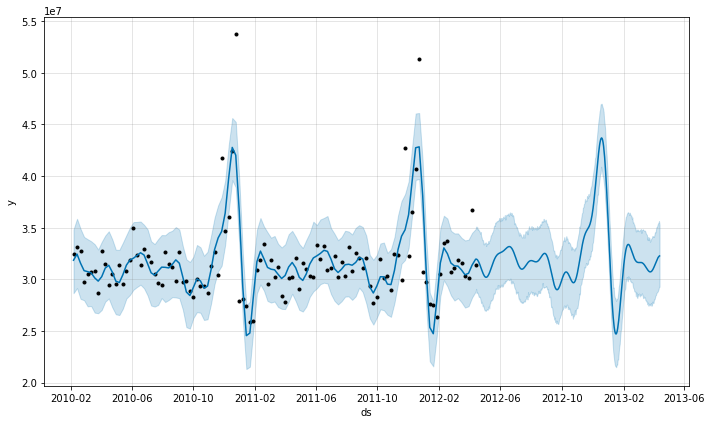

In [63]:
run_prophet(train2)

### Next the data was sliced to match up with the dates of the test dataset.

In [64]:
forecast.set_index('ds',inplace = True)
trainfinalcut = forecast['2012-04-20' : '2012-10-26']
trainfinalcut.reset_index(inplace=True)
trainfinalcut.rename(columns = {'ds':'Date','yhat':'Predicted_Weekly_Sales'},inplace=True)

/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### both train and test then had index set on "date" in order to join dataframes.

In [65]:
trainfinalcut.set_index('Date',inplace=True)
test2.set_index('Date', inplace=True)
dfjoined = trainfinalcut.join(test2)

### NaN values were removed from joined dataset and index was reset and columns were renamed

In [66]:
dfjoined2 = dfjoined[dfjoined['SUM(Weekly_Sales)'].notna()]
dfjoined2.reset_index(inplace=True)
dfjoined3 = dfjoined2[['Date','Predicted_Weekly_Sales','SUM(Weekly_Sales)','yhat_upper','yhat_lower']].copy()
dfjoined3.rename(columns = {'Predicted_Weekly_Sales':'Predicted Weekly Sales','SUM(Weekly_Sales)': 'Actual Weekly Sales','yhat_lower':'Lower Bound','yhat_upper':'Upper Bound'}, inplace = True)


### Root mean squared error was then used to assess model accuracy

In [67]:
from sklearn.metrics import mean_squared_error
mean_squared_error(dfjoined3['Actual Weekly Sales'], dfjoined3['Predicted Weekly Sales'], squared=False)

1181538.2880341604

### The data was then melted and plotted to show comparison in predicted and actual sales.

Text(0, 0.5, 'Weekly Sales (x 10m)')

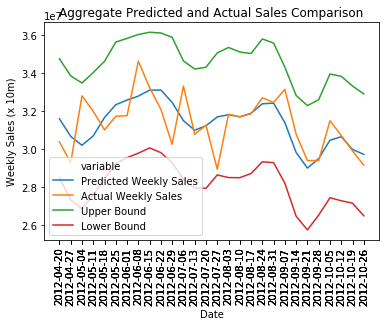

In [68]:
dfjoined3melted = pd.melt(dfjoined3, id_vars=['Date'], value_vars=['Predicted Weekly Sales', 'Actual Weekly Sales','Upper Bound', 'Lower Bound'])
dfjoined3melted.rename(columns = {'value':'Sales'},inplace=True)
import matplotlib.pyplot as plt
#fig, ax =plt.subplots()
ax = sns.lineplot(x = 'Date', y = 'Sales', hue = 'variable', data = dfjoined3melted)
ax.set_title('Aggregate Predicted and Actual Sales Comparison')
plt.xticks(dfjoined3melted["Date"], rotation=90)
plt.ylabel('Weekly Sales (x 10m)') 

### The conclusion from the root mean squared error and the visualization is that the model is fairly accurate at predicting aggregate weekly sales. The root mean squared error is 1,181,538 and the average of actual weekly sales is 31,354,980.

<a id='section2'></a>
# Section 2.
## This next section is the same process the first section, but predictions are made for each store individually.

In [69]:
df2 = pd.read_csv('trainOGcollapsed-sqft.csv')
#df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%y').dt.strftime('%Y-%m-%d')
#Use these next 2 lines if needing test/train split
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%y')
df2.set_index('Date', inplace=True)

In [70]:
train1 = df2['2010-02-05' : '2012-04-13']
test1 = df2['2012-04-20' : '2012-10-26']
train2 = train1.reset_index()
test2 = test1.reset_index()

### this is the same method as the previous section, but is done in a loop and the predictions are labeled by store number and compiled into a new dataframe.

In [75]:
trainRN = train2.rename(columns = {'Date':'ds','SUM(Weekly_Sales)':'y'})
def run_prophet_loop(dataframe):
    dff = pd.DataFrame()
    dff1 = pd.DataFrame()
    for num in range(1,46):
        df3 = dataframe[dataframe.Store == num]
        #df4 = df3.loc[:,['Date', 'SUM(Weekly_Sales)']]

        m = Prophet()
        x = m.fit(df3)

        future = m.make_future_dataframe(periods=365)
        future.tail()

        dff = m.predict(future)
        #dff[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        dff['Store'] = num
        dff1 = dff1.append(dff)
        print("store" + str(num))
        forecast = m.predict(future)
        fig1 = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store1


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store2


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store3


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store4


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store5


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store6


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store7


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store8


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store9


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store10


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store11


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store12


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store13


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store14


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store15


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store16


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store17


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store18


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store19


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store20


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store21


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store22


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store23


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store24


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store25


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store26


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store27


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store28


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store29


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store30


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store31


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store32


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store33


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store34


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store35


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store36


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store37


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store38


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store39


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store40


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store41


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store42


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store43


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store44


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


store45


/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)


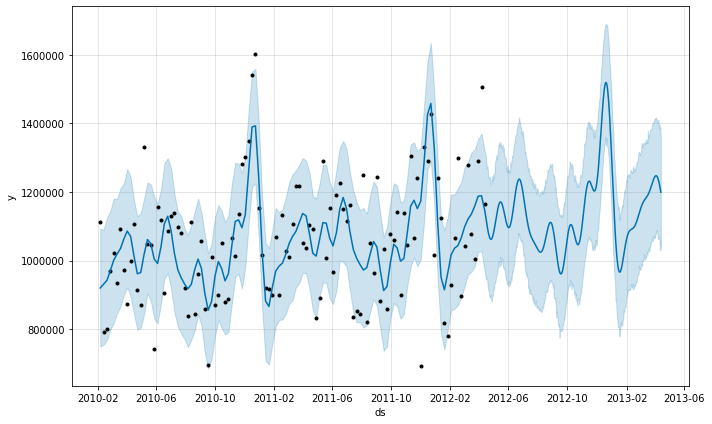

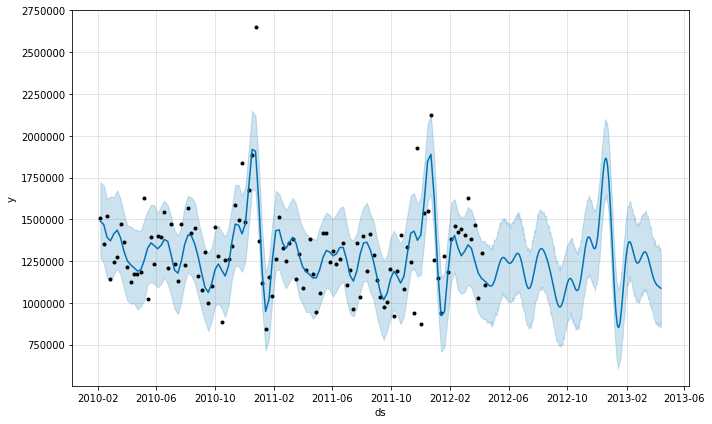

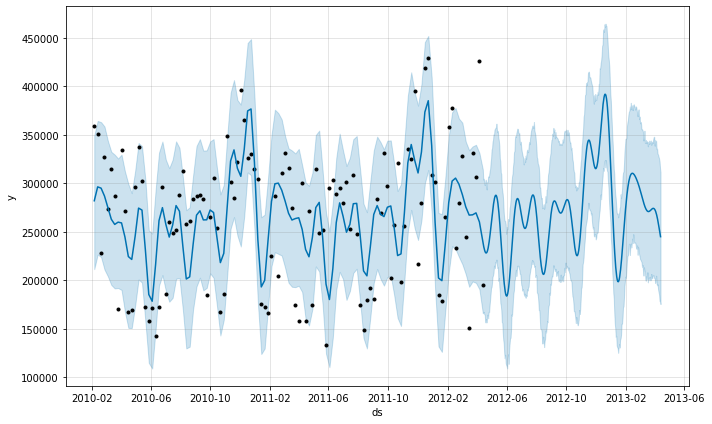

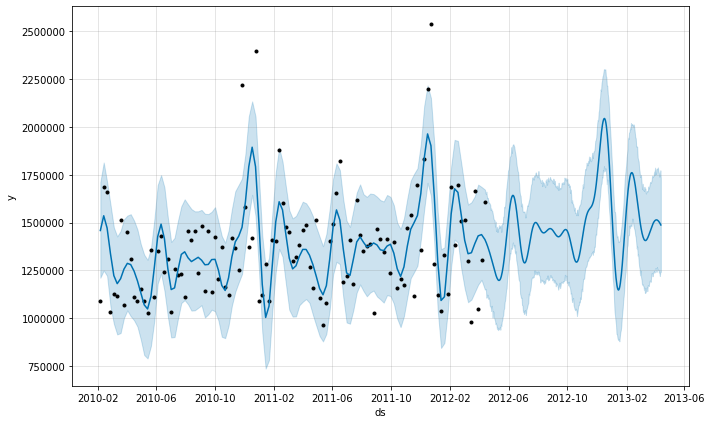

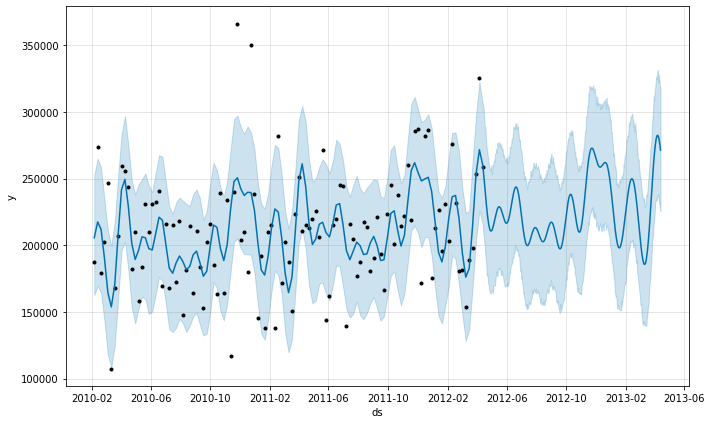

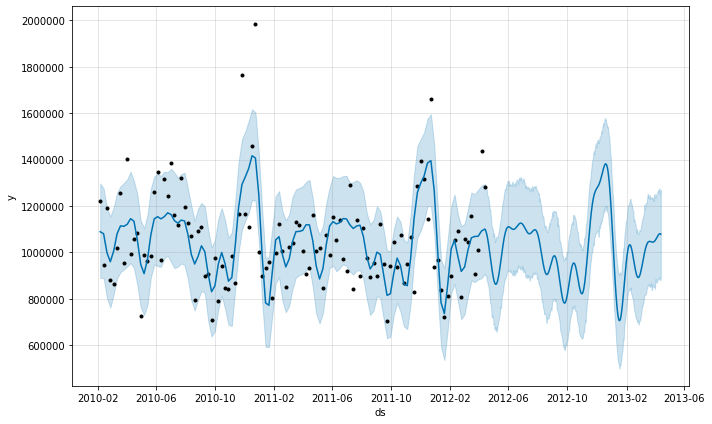

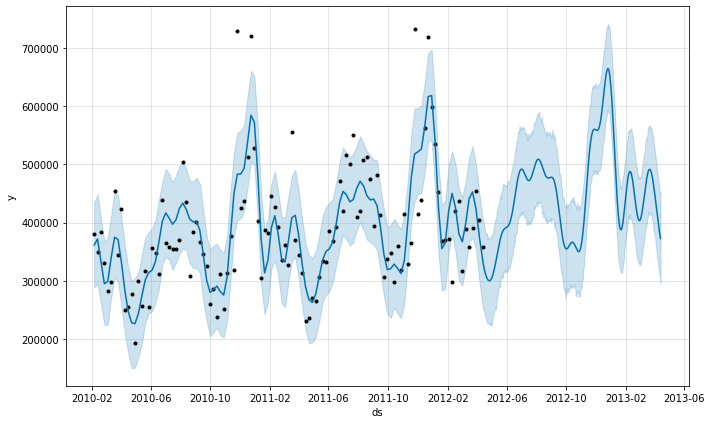

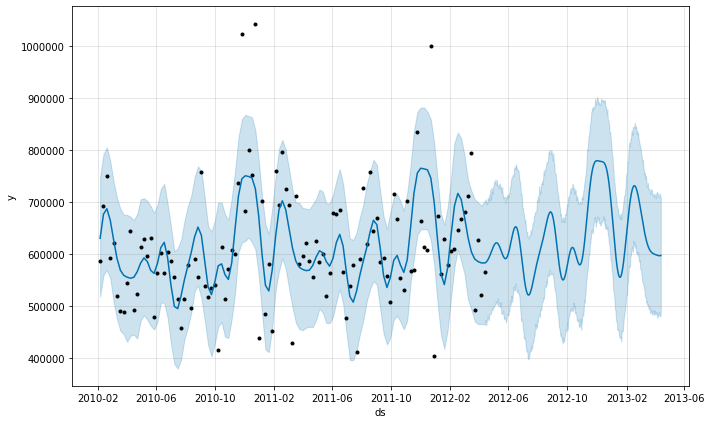

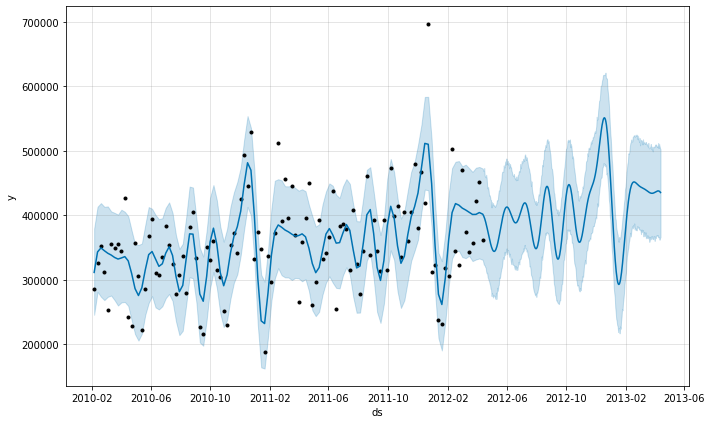

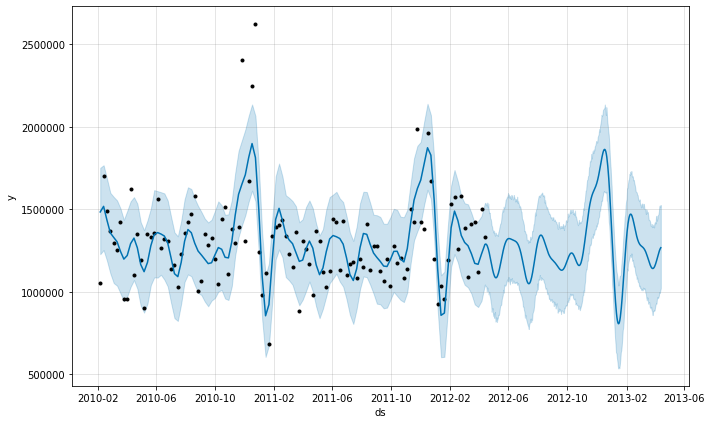

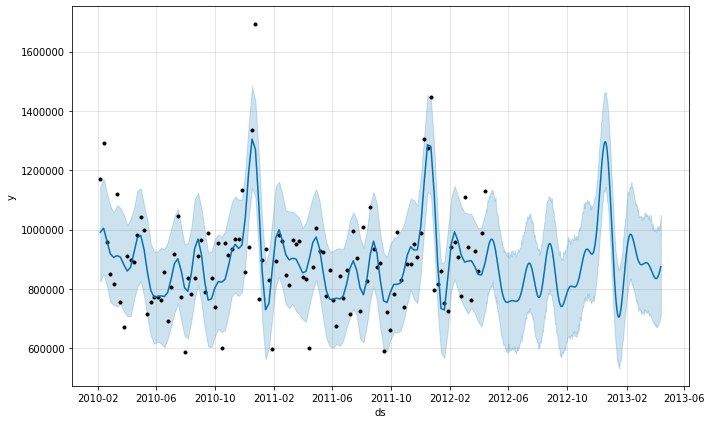

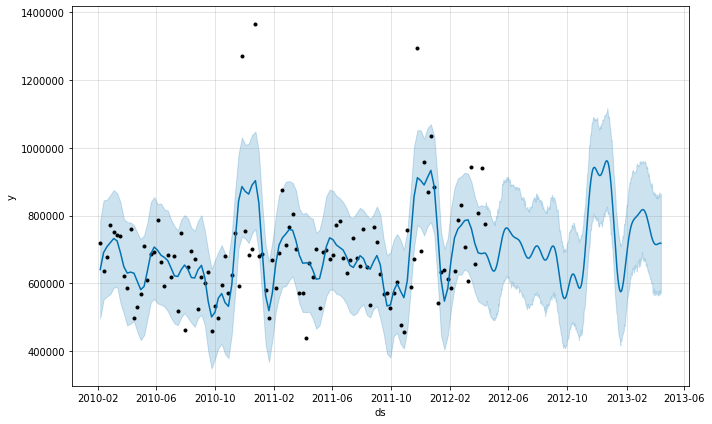

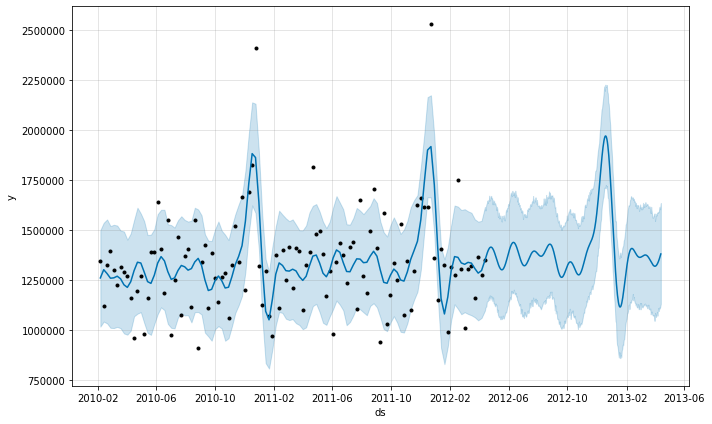

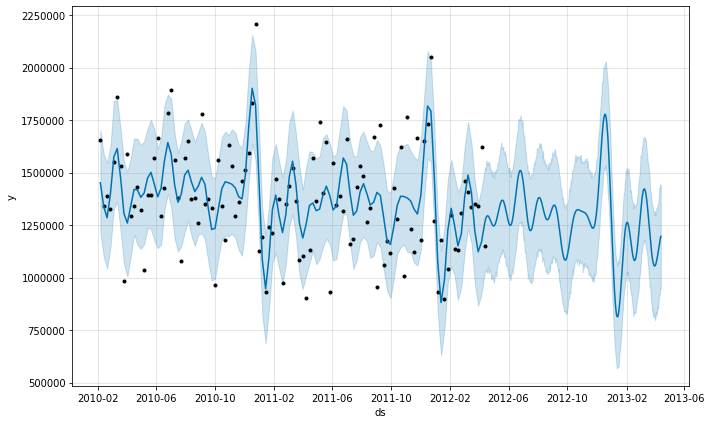

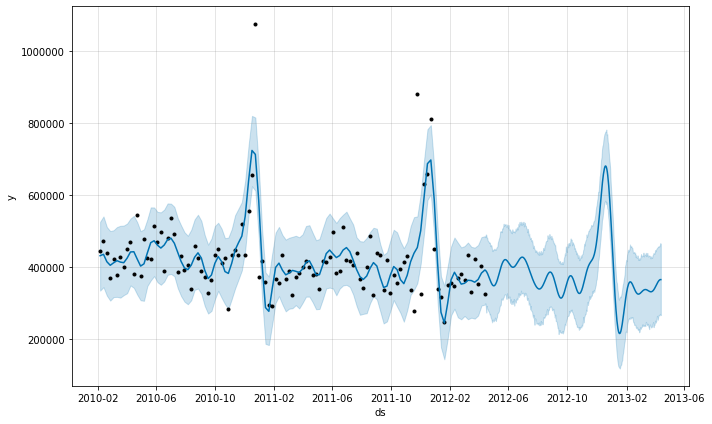

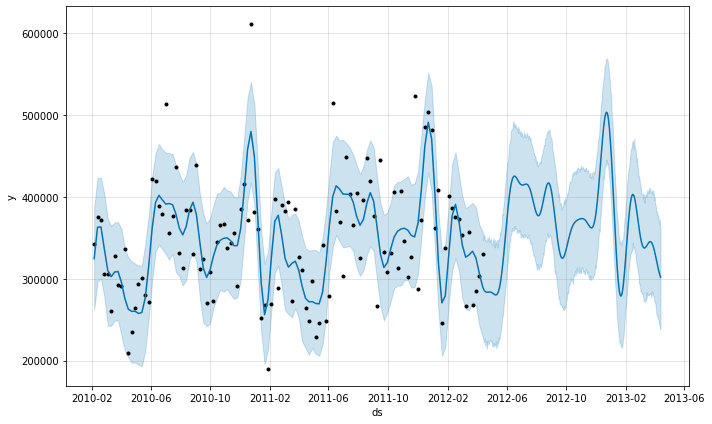

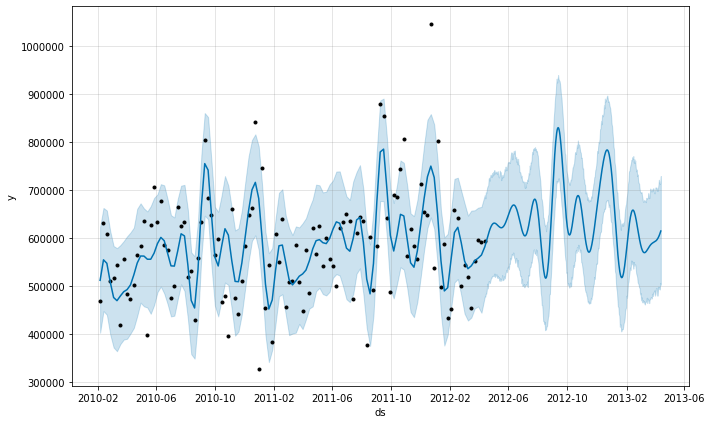

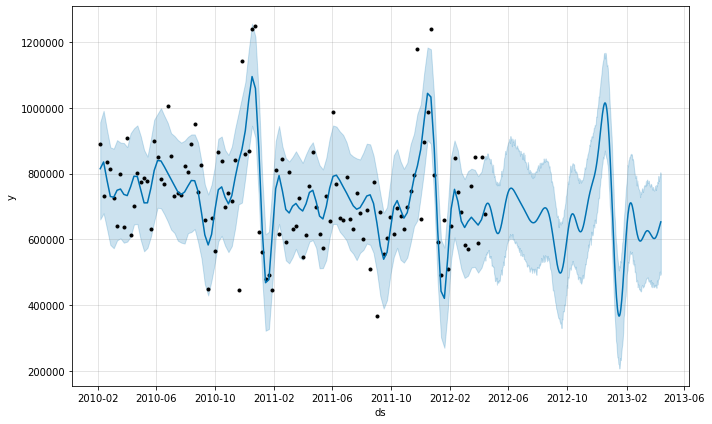

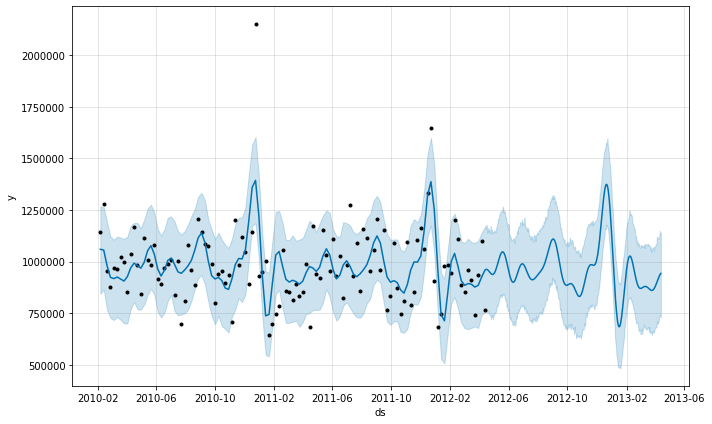

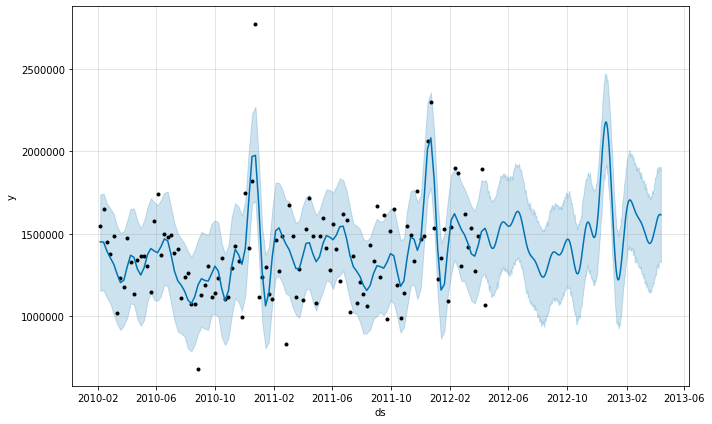

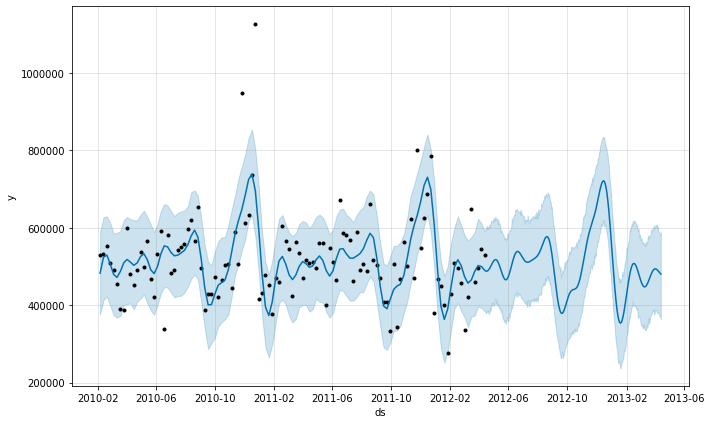

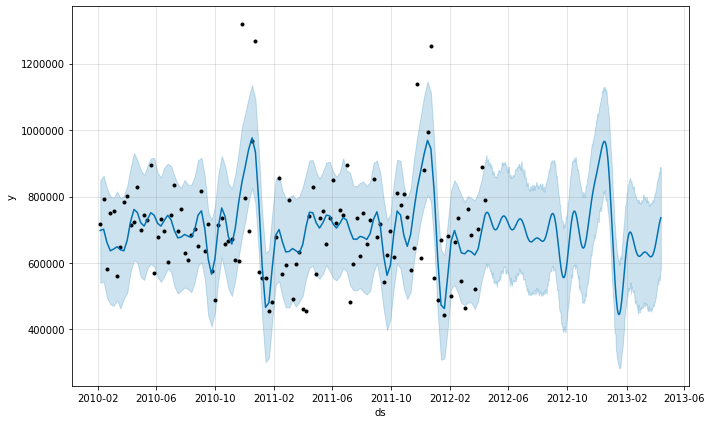

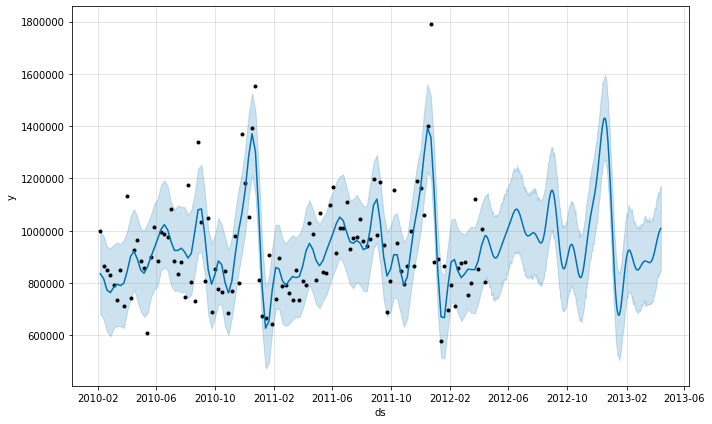

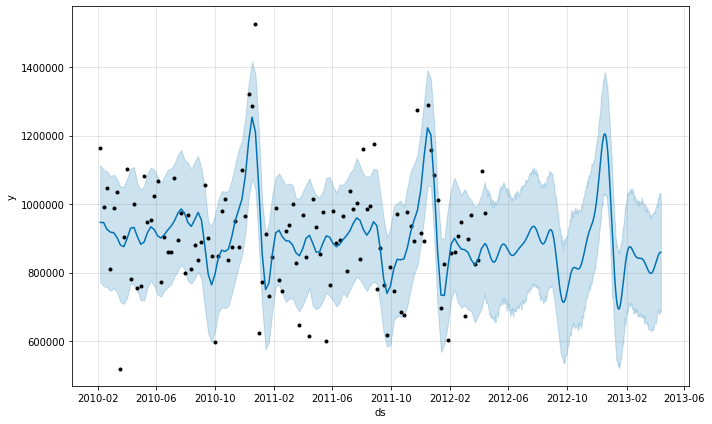

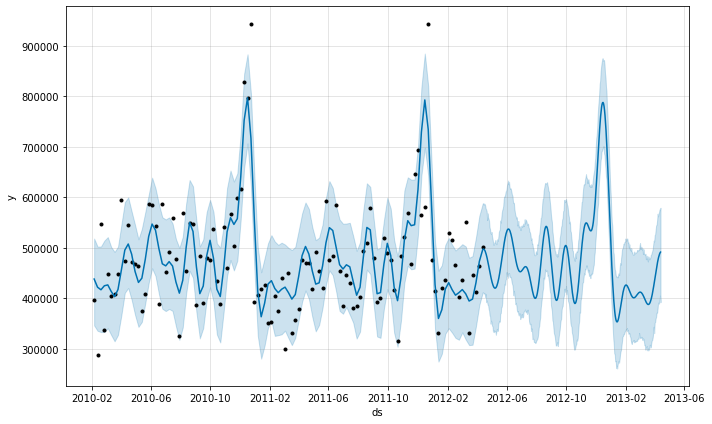

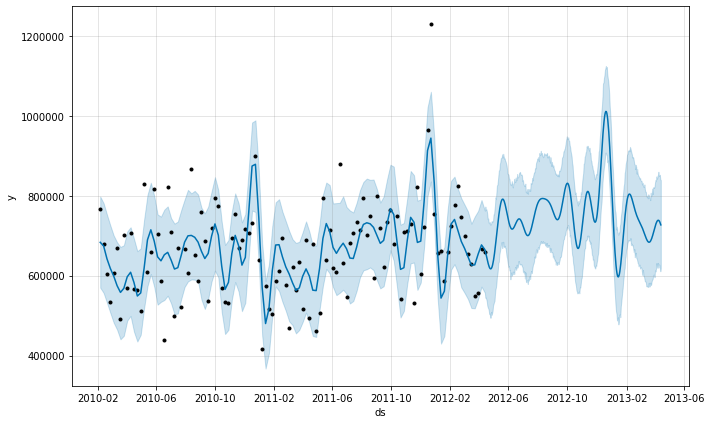

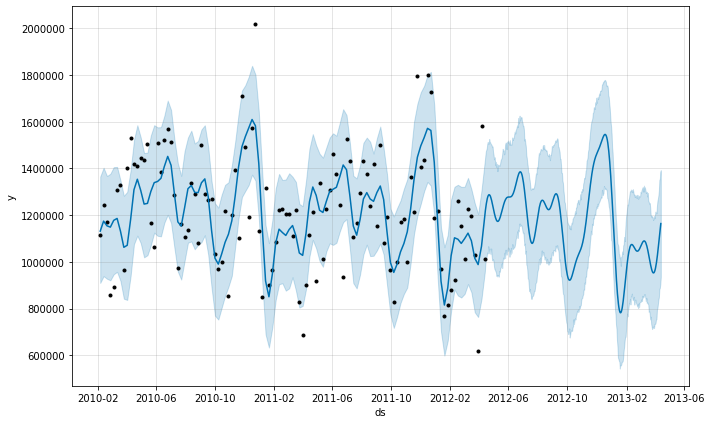

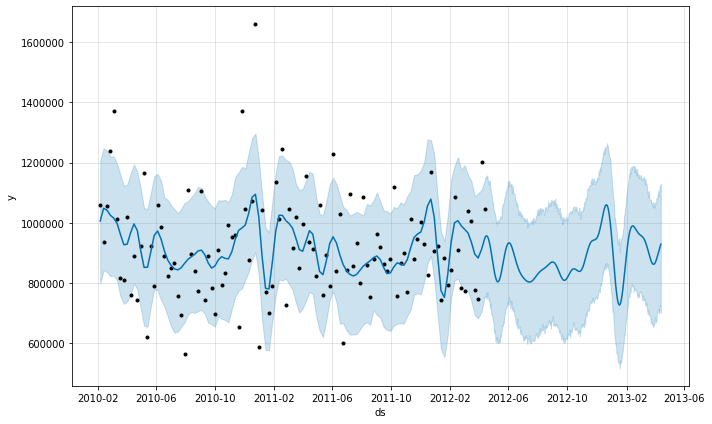

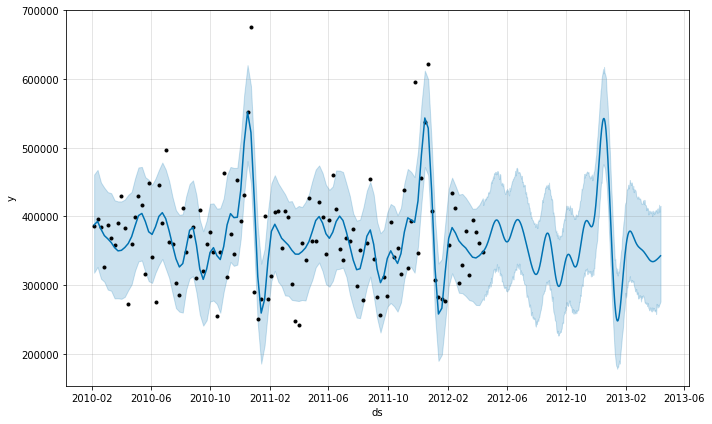

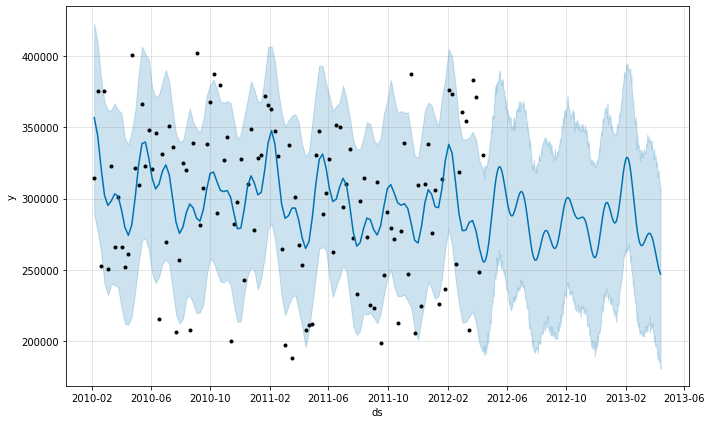

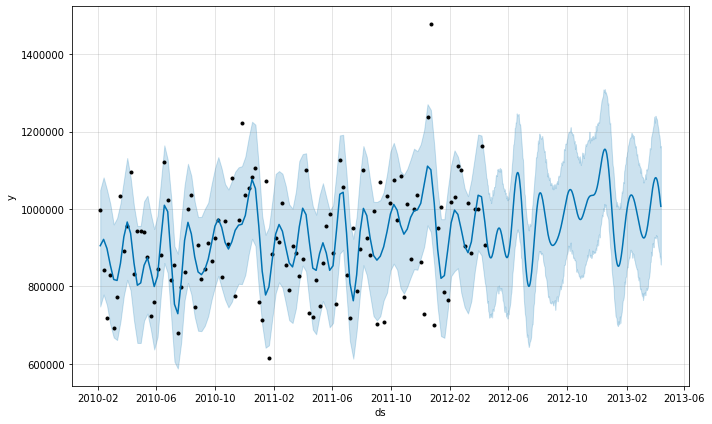

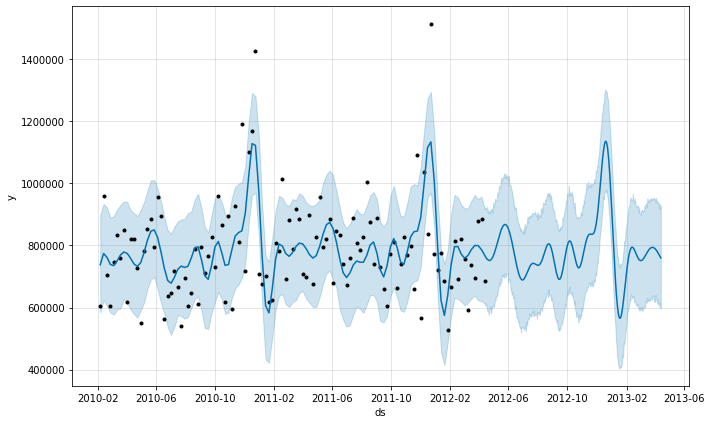

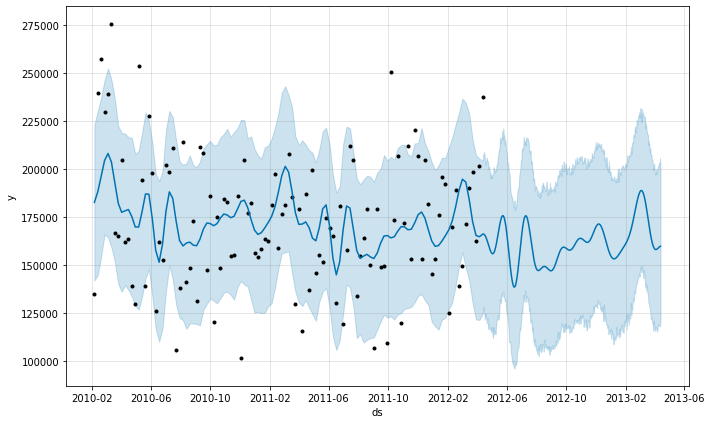

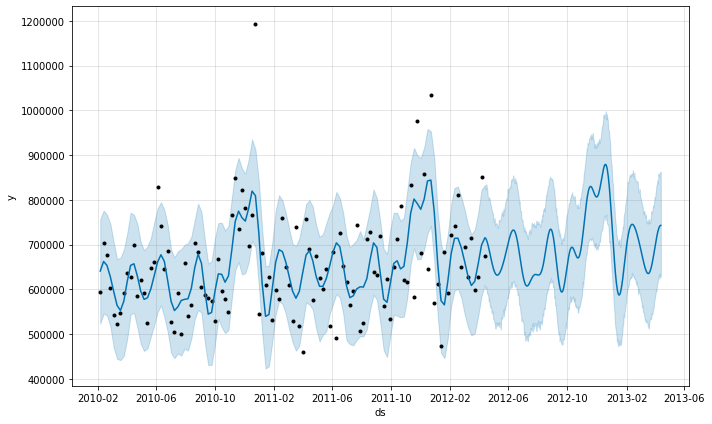

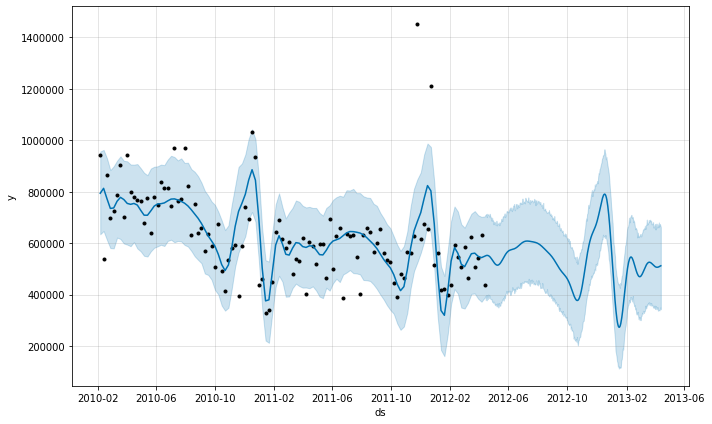

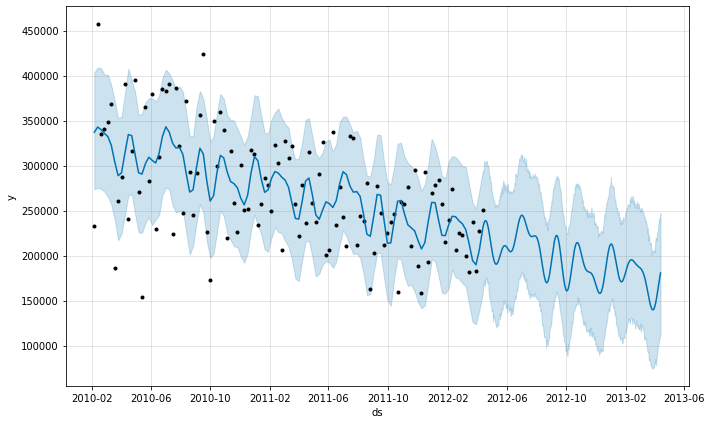

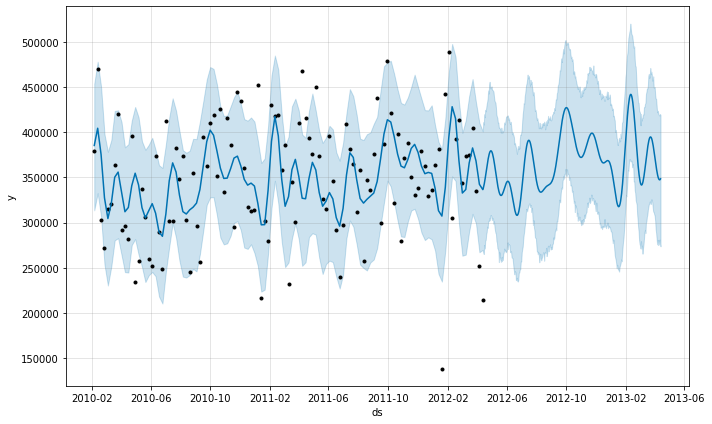

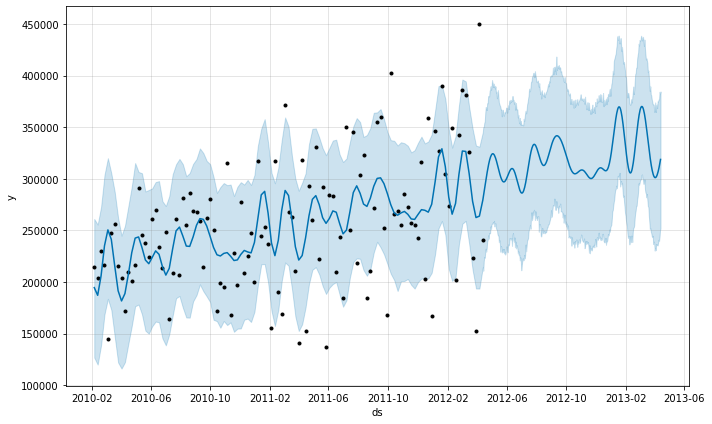

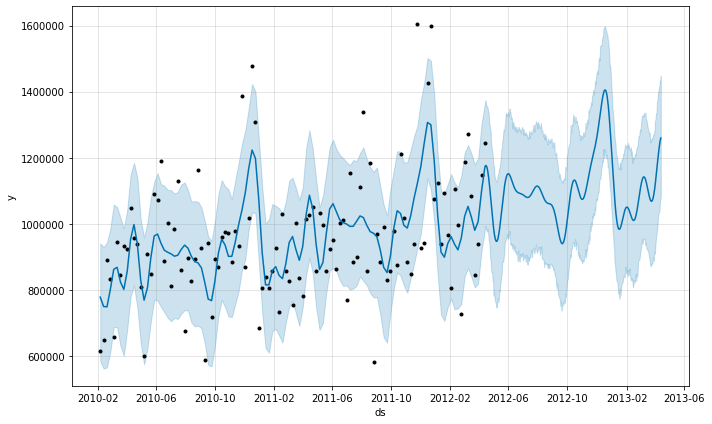

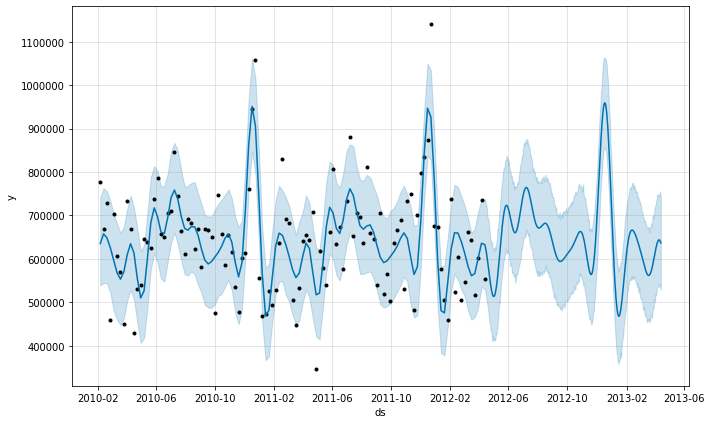

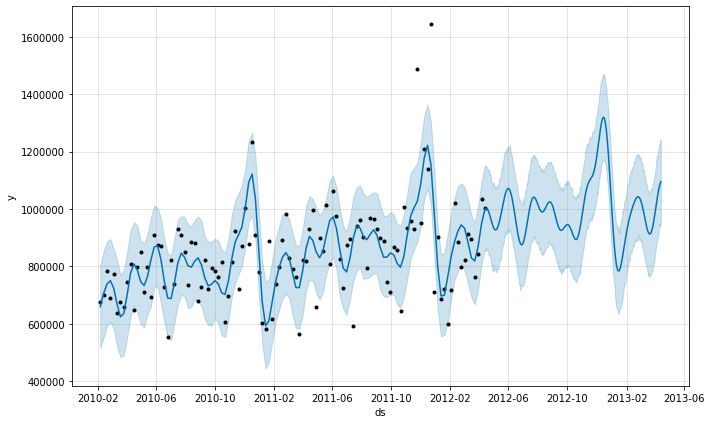

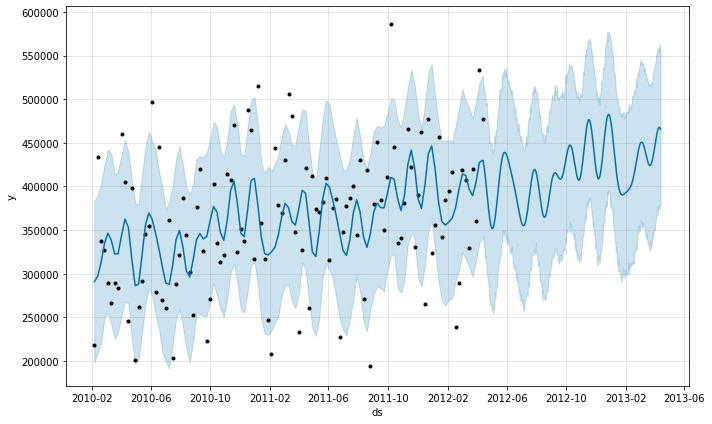

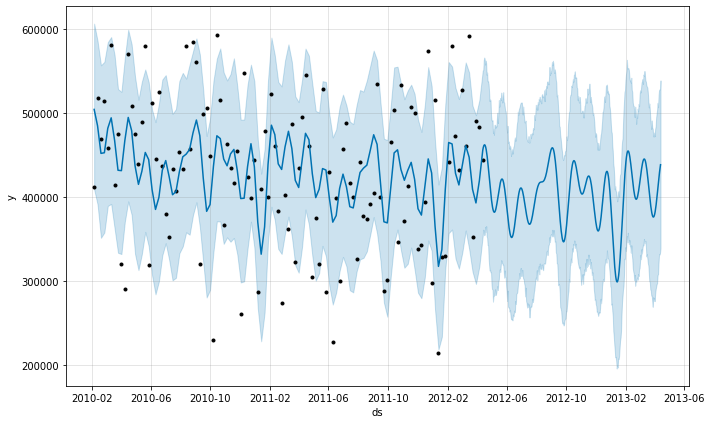

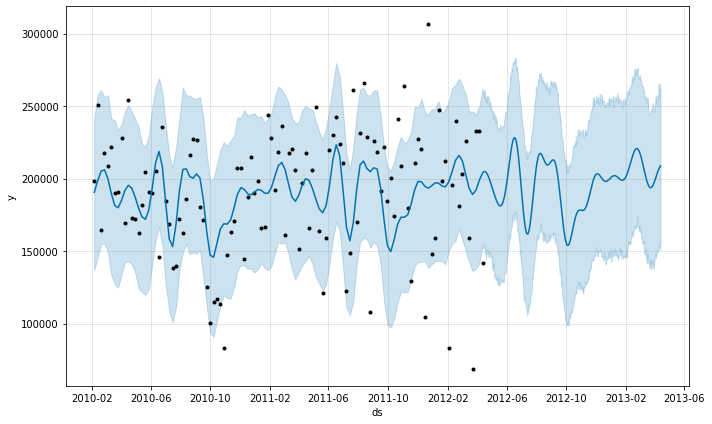

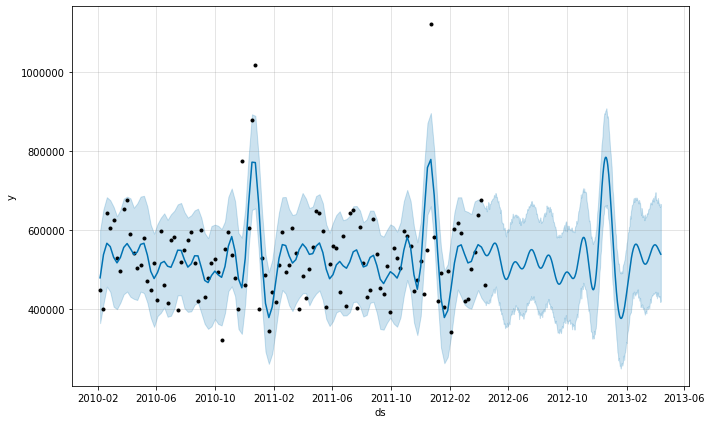

In [76]:
run_prophet_loop(trainRN)

### At this point I needed to join the predictions dataframe to the test dataframe, I decided to export the two dataframes to csv and join them in SQL and then read the joined CSV back into python. 

In [77]:
dff1.to_csv('TrainStorePredictions.csv')
test2.to_csv('TestStoreActuals.csv')

In [78]:
joined = pd.read_csv('joinedtesttrainStore.csv')

### The resulting dataframe lists the information we need to further analyze the predictions.

In [81]:
joined.rename(columns={'yhat_lower':'Lower Bound','yhat_upper':'Upper Bound',
        'SUM(Weekly_Sales)':'Actual Sales','yhat':'Predicted Sales'}, inplace=True)
joined.head()

Date  Store    Lower Bound   Upper Bound  Predicted Sales  \
0  2012-04-20      1  922218.883966  1.256197e+06     1.082751e+06   
1  2012-04-27      1  900812.549706  1.242784e+06     1.063239e+06   
2  2012-05-04      1  929042.974785  1.276154e+06     1.103783e+06   
3  2012-05-11      1  985706.333820  1.319498e+06     1.158314e+06   
4  2012-05-18      1  997878.767759  1.355596e+06     1.167100e+06   

   Actual Sales  
0     828265.16  
1     937855.79  
2    1334152.98  
3    1089849.10  
4    1090975.55

### Next a loop was performed that would calculate the mean squared error for each store and populate a list with the values as well as produce a visualization.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/matt/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

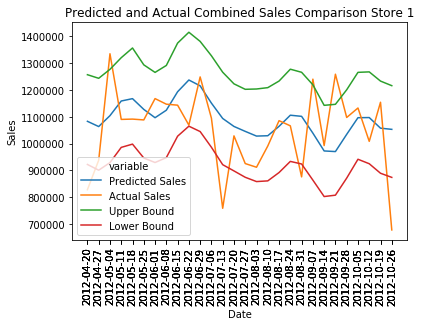

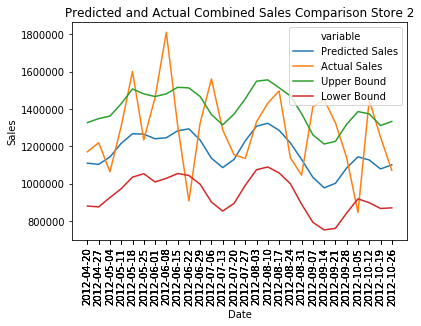

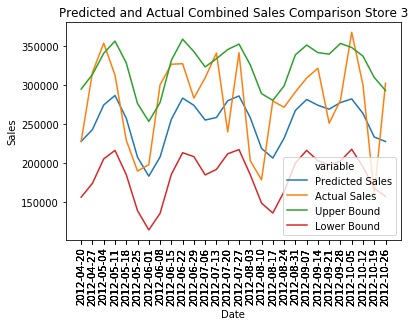

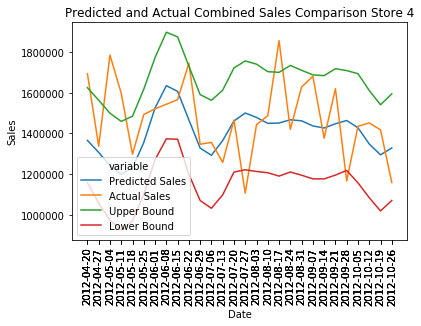

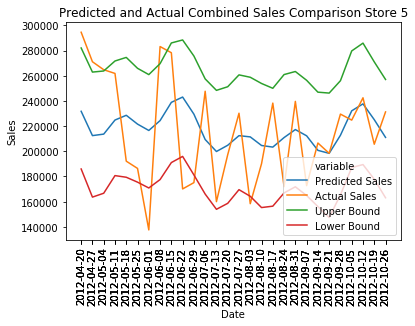

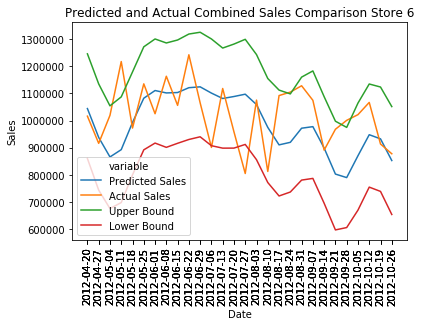

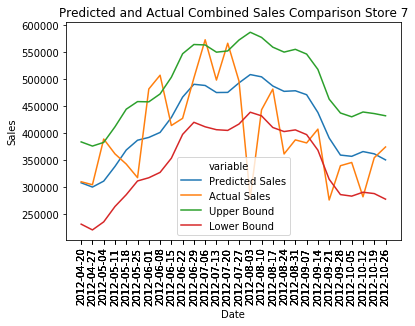

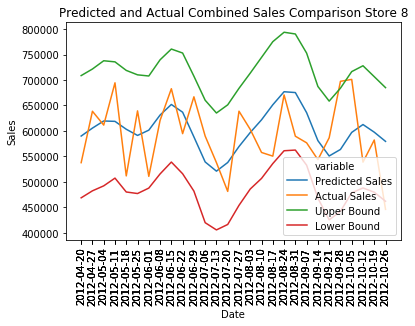

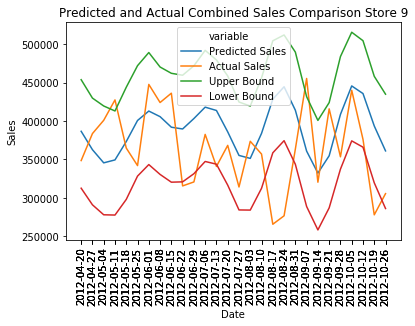

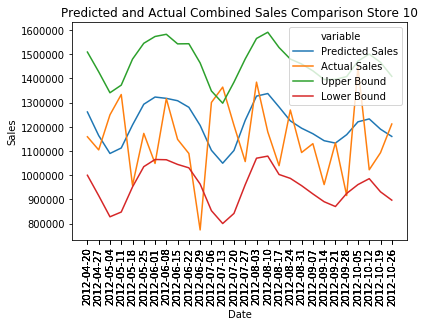

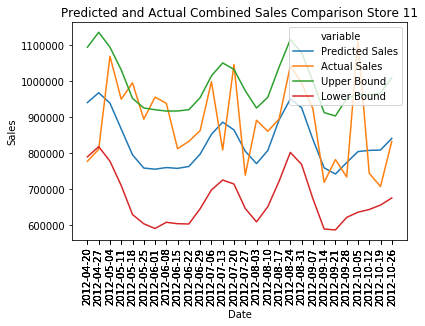

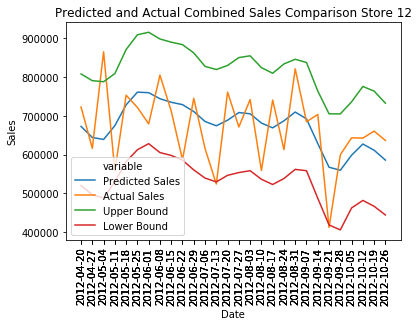

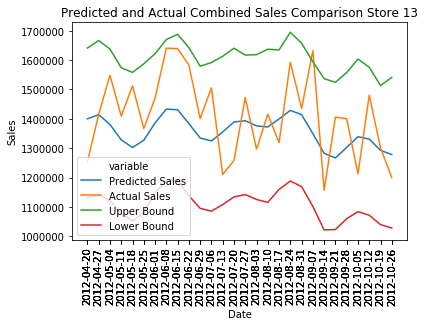

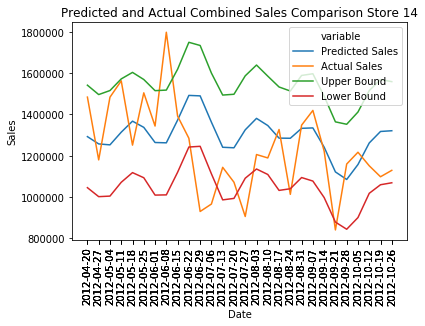

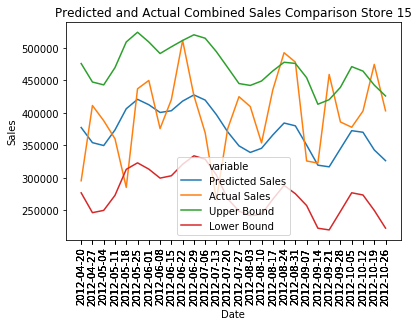

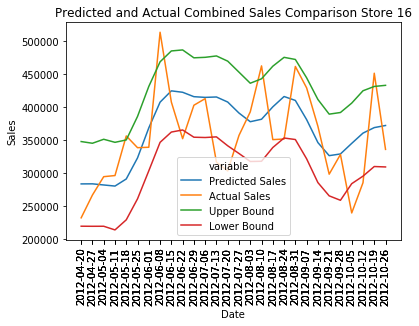

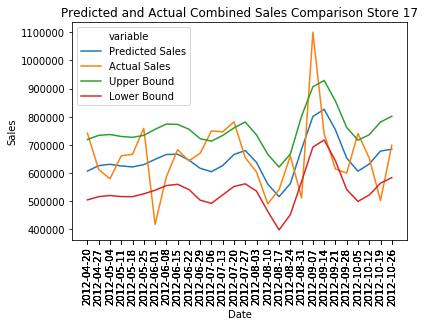

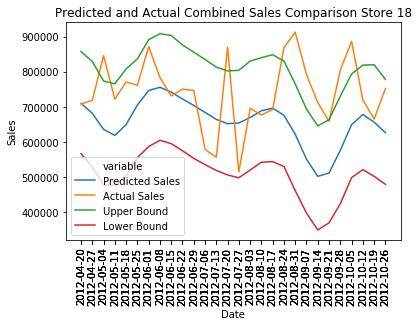

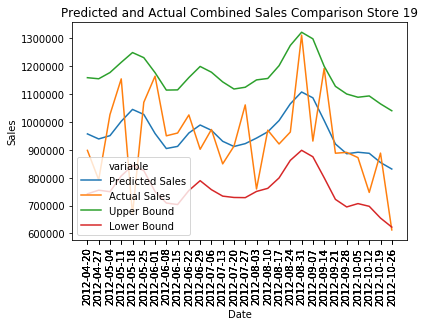

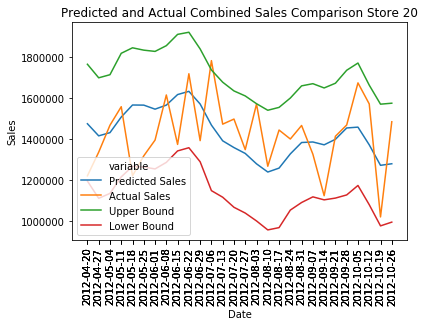

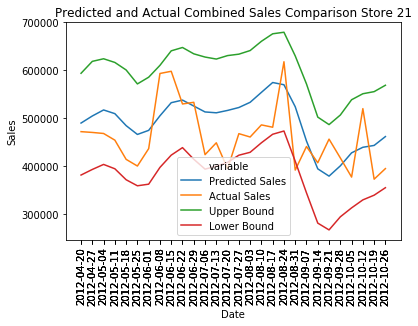

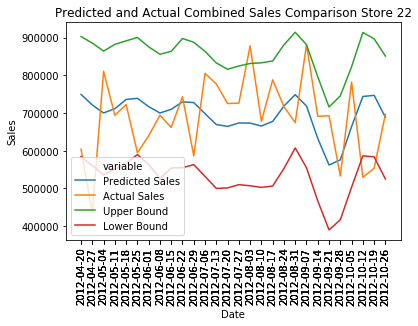

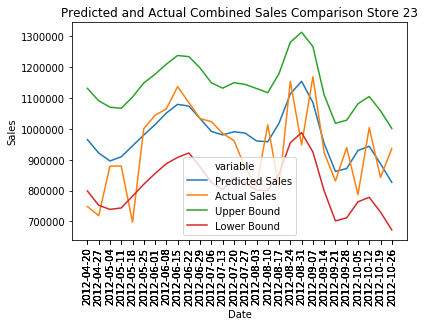

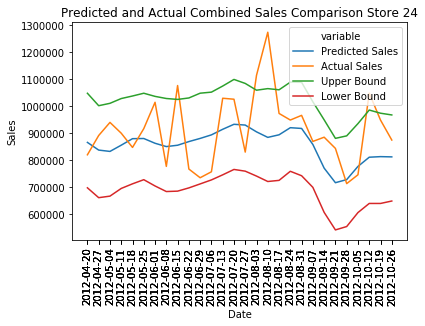

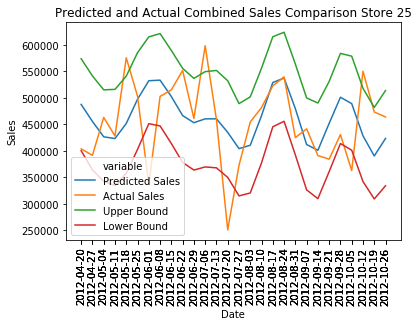

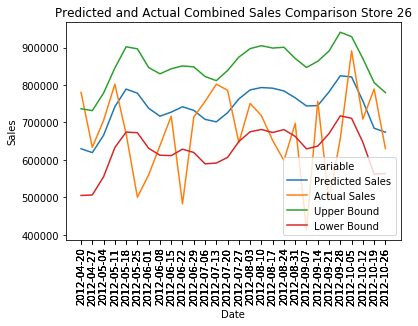

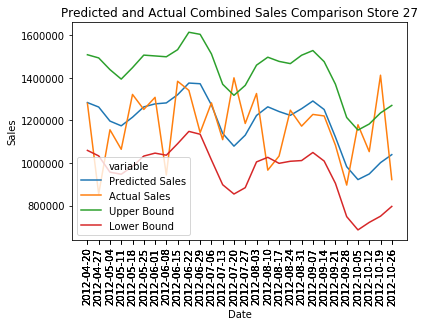

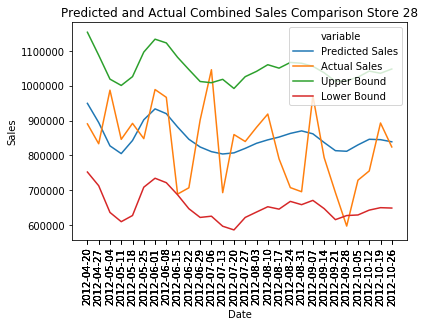

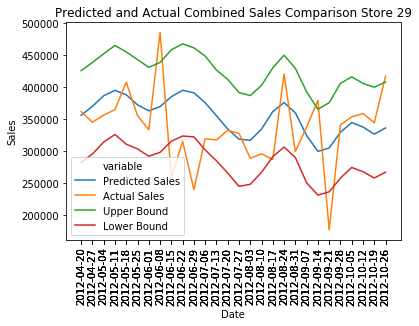

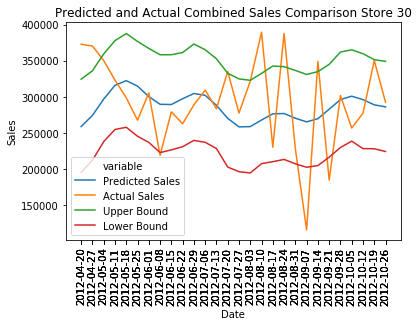

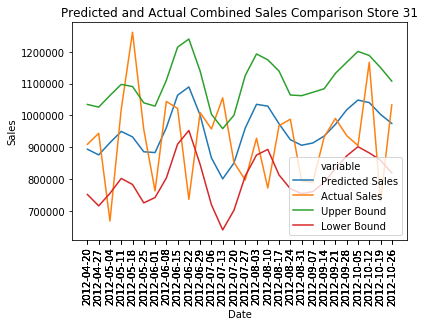

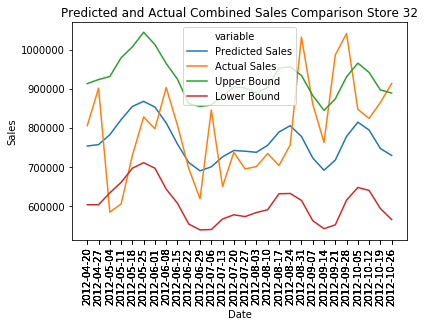

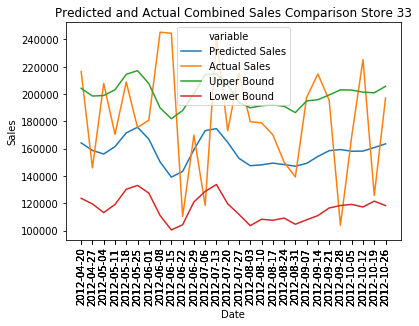

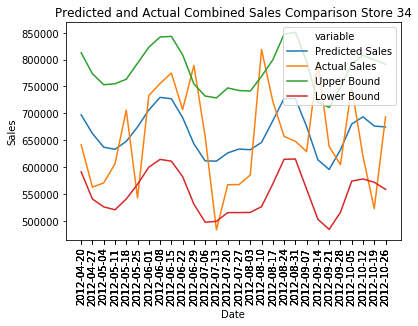

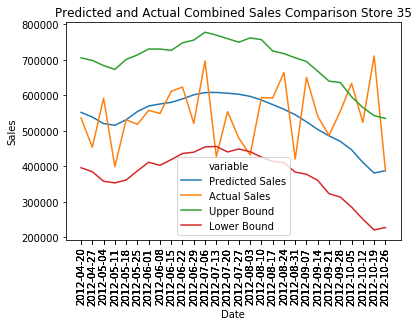

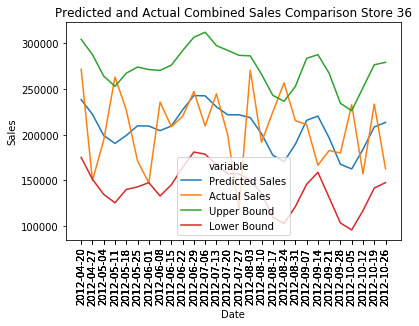

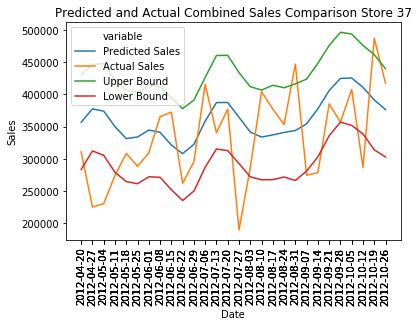

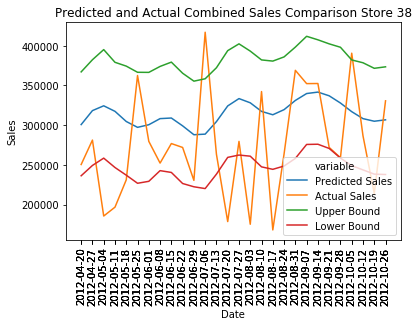

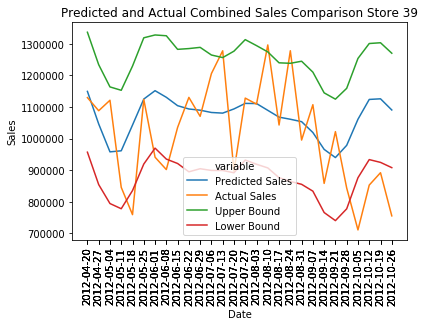

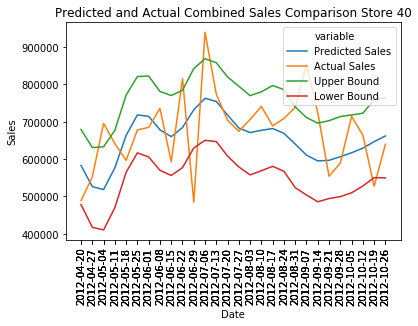

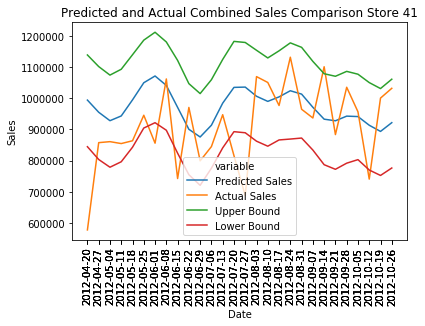

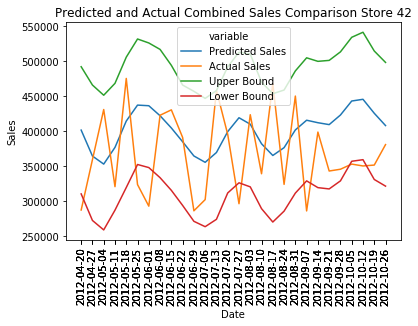

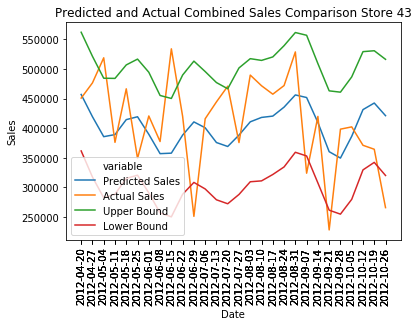

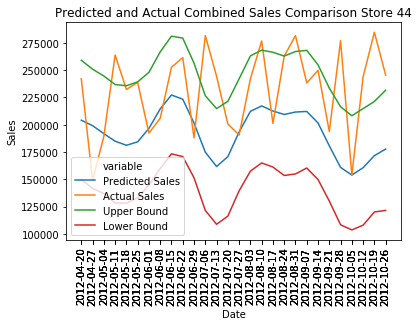

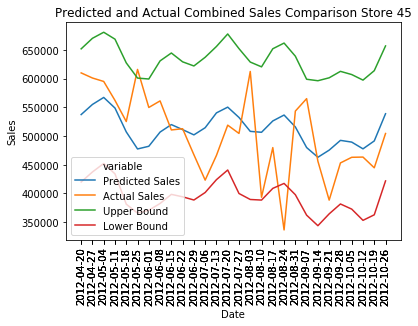

In [82]:
MSElist = []
dd = pd.DataFrame()
dd1 = pd.DataFrame()
for num in range(1,46):
    dd = joined[joined.Store==num]
    MSE = mean_squared_error(dd['Actual Sales'], dd['Predicted Sales'], squared=False)
    MSElist.append(MSE)
    ddmelted = pd.melt(dd, id_vars=['Date'], 
                value_vars=['Predicted Sales', 'Actual Sales','Upper Bound', 'Lower Bound'])
    ddmeltedfinal = ddmelted.rename(columns = {'value':'Sales'})
    plt.figure(num)
    ax = sns.lineplot(x = 'Date', y = 'Sales', hue = 'variable', data = ddmeltedfinal)
                .set_title('Predicted and Actual Combined Sales Comparison Store '+str(num))
    plt.xticks(ddmeltedfinal["Date"], rotation=90)

### The populated list was then converted to a dataframe. To show the description of the errors, the describe method is called on it and a boxplot is made.

                RMSE
count      45.000000
mean   111602.770407
std     51311.164891
min     40511.709951
25%     70544.334317
50%    108741.006797
75%    140807.938341
max    243895.677893


Text(0.5, 1.0, 'Root Mean Squared Error of Store Predictions (Weekly Sales)')

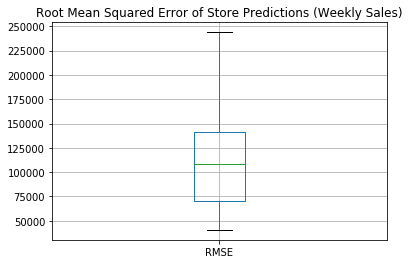

In [85]:
MSEdf = pd.DataFrame({'RMSE': MSElist})
print(MSEdf.describe())
MSEdf.boxplot().set_title("Root Mean Squared Error of Store Predictions (Weekly Sales)")

### As can be seen in the visualizations for the stores, the model is not as accurate in predicting sales of individual stores, however the average root mean squared error is 111,602 and actual average weekly sales are 696,777, so while not as good, it is still decent.

<a id='section3'></a>
# Section 3.

## In this next section an analasys was performed on the individual stores characteristics with respect to the error of the predictions. 

### A CSV containing the characteristics for each store was read into a dataframe and joined with the root mean squared errors to analyze any relationship that might exist. 

In [88]:
dfchars = pd.read_csv('StoreChars.csv')
MSEjoined = dfchars.join(MSEdf)

In [96]:
MSEjoined.corr(method='pearson')['RMSE'].sort_values()

Store                 -0.276787
AVG(s.Unemployment)   -0.075627
AVG(s.Temperature)    -0.075133
AVG(s.CPI)            -0.052850
AVG(s.Fuel_Price)      0.037435
Weekly_Sales_sqft      0.173462
SUM(s.MarkDown5)       0.608104
SUM(s.Markdown3)       0.705241
SUM(s.MarkDown1)       0.723650
Size                   0.744728
SUM(s.MarkDown4)       0.744757
SUM(s.MarkDown2)       0.792993
SUM(s.Weekly_Sales)    0.918025
RMSE                   1.000000
Name: RMSE, dtype: float64

### The main correlation with RMSE is weekly sales, which is intuitive, since as the sales go higher so does the error, and the other correlations are those that are also correlated with high weekly sales. So there really isnt anything noteworthy discovered here.

<a id='section4'></a>
# Section 4. 

## In this last section the analysis is done on the individual store predictions with respect to the issues listed in the issue tree portion of the problem statement. 

### The predictions from section 2 were exported to a CSV and I used SQL to summarize and join that data with the store characteristics data so that insights could be explored. 

In [115]:
wmdata = pd.read_csv('StorePredictionsCharsfinal2.csv')
wmdata.rename(columns={'AVGyhat_sqft':'Pred Weekly Sales Sqft'},inplace=True)
wmdata.head()

Store  SUM(yhat_lower)  SUM(yhat_upper)     SUM(yhat)  AVG(yhat_lower)  \
0      1     4.555944e+08     6.179205e+08  5.366880e+08     9.491549e+05   
1     10     4.929606e+08     7.372760e+08  6.151021e+08     1.027001e+06   
2     11     3.468574e+08     5.010745e+08  4.240089e+08     7.226196e+05   
3     12     2.733897e+08     4.125257e+08  3.431170e+08     5.695619e+05   
4     13     5.434078e+08     7.828398e+08  6.630444e+08     1.132100e+06   

   AVG(yhat_upper)     AVG(yhat)    Size  Pred Weekly Sales Sqft        MD1  \
0     1.287334e+06  1.118100e+06  151315                7.389221  412629.08   
1     1.535992e+06  1.281463e+06  126512               10.129179  497532.04   
2     1.043905e+06  8.833519e+05  207499                4.257138  452859.91   
3     8.594285e+05  7.148270e+05  112238                6.368851  577680.84   
4     1.630916e+06  1.381343e+06  219622                6.289636  567637.29   

   ...        MD3        MD4        MD5     Tempav    Fuelav       CPIav  \
0  ...   61270.02  191050.32  255951.40  68.306783  3.219699  215.996892   
1  ...  154483.08  222533.75  276186.92  72.241189  3.575923  128.679669   
2  ...   79826.66  181680.55  283991.75  72.480769  3.219699  219.391531   
3  ...   69823.84  257727.18  292062.85  70.262797  3.606420  128.679669   
4  ...  143396.07  255567.35  370120.44  53.697133  3.286147  128.679669   

   Unemploymentav  Type   Total_Sales  S.Actualav / S.Size  
0        7.610420     A  1.506943e+08             6.964320  
1        8.362965     B  1.822130e+08            10.071904  
2        7.176986     A  1.275856e+08             4.299813  
3       13.116483     B  9.729430e+07             6.061937  
4        7.001825     A  1.930788e+08             6.147844  

[5 rows x 21 columns]

[Text(0, 0.5, 'Avereage Weekly Sales/sqft (cents)'),
 Text(0.5, 0, 'Store Size')]

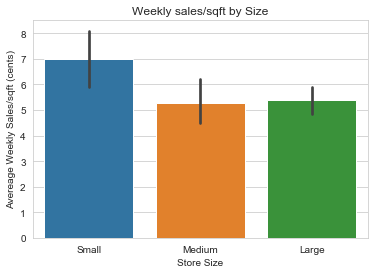

In [116]:
sns.set_style('whitegrid')
cut_labels_size = ['Small', 'Medium', 'Large']
cut_bins = [0, 75000, 175000, 225000]
wmdata['SizeCat'] = pd.cut(wmdata['Size'], bins=cut_bins, labels=cut_labels_size)
bp1 = sns.barplot(x='SizeCat', y='Pred Weekly Sales Sqft', data=wmdata)
bp1.set_title('Weekly sales/sqft by Size')
bp1.set(xlabel='Store Size', ylabel='Avereage Weekly Sales/sqft (cents)')

### Small stores had the hights predicted weekly sales per squarefoot, medium size and large stores were pretty much equal.

[Text(0, 0.5, 'Avereage Weekly Sales/sqft (cents)'),
 Text(0.5, 0, 'Store Type')]

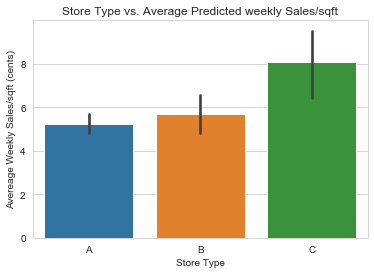

In [117]:
sns.set_style('whitegrid')
bp1 = sns.barplot(x='Type', y='Pred Weekly Sales Sqft', data=wmdata)
bp1.set_title('Store Type vs. Average Predicted weekly Sales/sqft')
bp1.set(xlabel='Store Type', ylabel='Avereage Weekly Sales/sqft (cents)')

### Type C stores had the highest predicted weekly sales per square foot, followed by type B, then type C. 

[Text(0, 0.5, 'Avereage Predicted Weekly Sales/sqft (cents)'),
 Text(0.5, 0, 'Climate')]

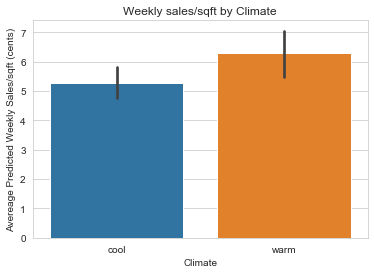

In [118]:
cut_labels_climate = ['cool', 'warm']
cut_bins = [0, 60, 120]
wmdata['climate'] = pd.cut(wmdata['Tempav'], bins=cut_bins, labels=cut_labels_climate)
sns.set_style('whitegrid')
bp1 = sns.barplot(x='climate', y='Pred Weekly Sales Sqft', data=wmdata)
bp1.set_title('Weekly sales/sqft by Climate')
bp1.set(xlabel='Climate', ylabel='Avereage Predicted Weekly Sales/sqft (cents)')

### Warm climate stores had higher predicted average weekly sales per squarefoot than cool climate stores.

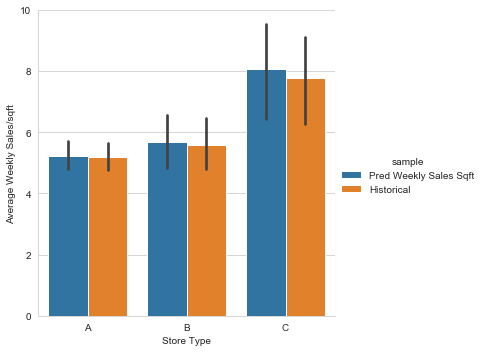

In [119]:
wmdata3=wmdata[['Pred Weekly Sales Sqft','S.Actualav / S.Size','Type']].copy()
wmdata3.rename(columns = {'AVGyhat_sqft':'Predicted'}, inplace = True)
wmdata3.rename(columns = {'S.Actualav / S.Size':'Historical'}, inplace = True)
wmdata3.rename(columns = {'Type':'Store Type'}, inplace = True)
melted = pd.melt(wmdata3, id_vars = 'Store Type', var_name='sample', value_name='Average Weekly Sales/sqft')


sns.catplot(x='Store Type', y='Average Weekly Sales/sqft', hue='sample', data=melted, kind='bar')


### All 3 types of stores showed a future upward trend, although type C stores appeared to treand high than type B and type B high than type A.

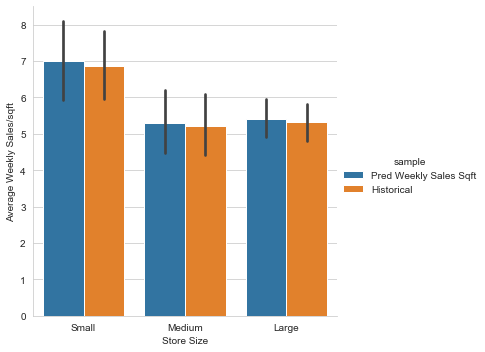

In [123]:
cut_labels_size = ['Small', 'Medium', 'Large']
cut_bins = [0, 75000, 175000, 225000]
wmdata['SizeCat'] = pd.cut(wmdata['Size'], bins=cut_bins, labels=cut_labels_size)
wmdata4=wmdata[['Pred Weekly Sales Sqft','S.Actualav / S.Size','SizeCat']].copy()
wmdata4.rename(columns = {'AVGyhat_sqft':'Predicted'}, inplace = True)
wmdata4.rename(columns = {'S.Actualav / S.Size':'Historical'}, inplace = True)
wmdata4.rename(columns = {'SizeCat':'Store Size'}, inplace = True)
melted = pd.melt(wmdata4, id_vars = 'Store Size', var_name='sample', value_name='Average Weekly Sales/sqft')


sns.catplot(x='Store Size', y='Average Weekly Sales/sqft', hue='sample', data=melted, kind='bar')

### All size groups of stores showed a failr equal slight upward trend.